# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 設置繁體中文字型
rcParams['font.family'] = 'Microsoft JhengHei'  # 微軟正黑體
rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# Data

In [2]:

# 下載VXX數據
vxx = yf.download("VXX", start="2019-01-01", end="2024-12-30")
vxx


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3102.080078,3123.072021,2908.159912,2927.360107,2927.360107,32108
2019-01-03,2982.399902,3114.239990,2962.560059,3048.959961,3048.959961,15936
2019-01-04,2931.840088,2945.919922,2798.719971,2807.040039,2807.040039,20398
2019-01-07,2785.919922,2825.087891,2710.399902,2744.320068,2744.320068,40055
2019-01-08,2696.959961,2791.679932,2680.320068,2688.639893,2688.639893,14770
...,...,...,...,...,...,...
2024-12-20,55.820000,55.980000,47.625000,48.080002,48.080002,10973900
2024-12-23,46.919998,48.820000,44.380001,44.380001,44.380001,4045900
2024-12-24,43.970001,44.049999,42.180000,42.279999,42.279999,2884300


# Def

In [3]:
class VIXBollingerStrategy:
    def __init__(self, data, period=20):
        """
        初始化布林帶策略
        :param data: VIX期貨數據
        :param period: 布林帶周期
        """
        self.data = data.copy()
        self.period = period
        
    def calculate_bollinger_bands(self):
        """計算布林帶"""
        # 計算移動平均線
        self.data['MA'] = self.data['Close'].rolling(window=self.period).mean()
        # 計算標準差
        rolling_std = self.data['Close'].rolling(window=self.period).std()
        
        # 計算布林帶（1個標準差和2個標準差）
        self.data['Upper_Band1'] = self.data['MA'] + rolling_std
        self.data['Lower_Band1'] = self.data['MA'] - rolling_std
        self.data['Upper_Band2'] = self.data['MA'] + 2 * rolling_std
        self.data['Lower_Band2'] = self.data['MA'] - 2 * rolling_std
        
        return self.data
    
    def calculate_signals(self):
        """計算交易信號"""
        # 初始化信號和倉位
        self.data['Signal'] = 0  # 信號欄位用於記錄當天產生的交易信號
        self.data['Position'] = 0  # 倉位欄位用於記錄實際持倉狀態
        
        # 多頭信號條件：從下往上突破第一條布林線上軌（1個標準差）
        long_signal = (self.data['Close'] > self.data['Upper_Band1']) & \
                     (self.data['Close'].shift(1) <= self.data['Upper_Band1'].shift(1))
        
        # 空頭信號條件：從上往下突破第一條布林線下軌（1個標準差）
        short_signal = (self.data['Close'] < self.data['Lower_Band1']) & \
                      (self.data['Close'].shift(1) >= self.data['Lower_Band1'].shift(1))
        
        # 設置信號
        self.data.loc[long_signal, 'Signal'] = 1
        self.data.loc[short_signal, 'Signal'] = -1
        
        # 設置隔日實際倉位
        self.data['Position'] = self.data['Signal'].shift(1)
        self.data['Position'] = self.data['Position'].fillna(0)
        
        # 遍歷並維持倉位直到遇到平倉條件
        current_position = 0
        for i in range(1, len(self.data)):
            # 如果有新的倉位信號
            if self.data['Position'].iloc[i] != 0:
                current_position = self.data['Position'].iloc[i]
            # 如果沒有新的倉位信號，保持當前倉位
            else:
                self.data.loc[self.data.index[i], 'Position'] = current_position
                
            # 處理平倉條件
            if current_position == 1:  # 持有多頭
                # 止盈：達到上軌2個標準差
                if self.data['Close'].iloc[i] >= self.data['Upper_Band2'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
                    current_position = 0
                # 止損：回落到均線
                elif self.data['Close'].iloc[i] <= self.data['MA'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
                    current_position = 0
                    
            elif current_position == -1:  # 持有空頭
                # 止盈：達到下軌2個標準差
                if self.data['Close'].iloc[i] <= self.data['Lower_Band2'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
                    current_position = 0
                # 止損：回升到均線
                elif self.data['Close'].iloc[i] >= self.data['MA'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
                    current_position = 0
    
        return self.data
    
    def backtest(self, initial_capital=100000):
        """
        回測策略
        :param initial_capital: 初始資金
        :return: 回測結果
        """
        # 初始化收益計算
        self.data['Returns'] = 0.0
        self.data['Cumulative_Returns'] = 1.0
        
        # 計算每日收益率
        # 使用開盤價計算收益率
        self.data['Open_Return'] = self.data['Open'].pct_change()
        
        # 只在有倉位時計算收益（使用當天的開盤價）
        self.data['Returns'] = self.data['Open_Return'] * self.data['Position']
        
        # 計算累積收益
        self.data['Cumulative_Returns'] = (1 + self.data['Returns']).cumprod()
        
        # 計算策略評估指標
        total_days = len(self.data)
        active_days = (self.data['Position'] != 0).sum()
        
        if total_days > 0:
            total_return = self.data['Cumulative_Returns'].iloc[-1] - 1
            annual_return = total_return / (total_days / 252)
            
            trading_returns = self.data['Returns']
            sharpe_ratio = np.sqrt(252) * (trading_returns.mean() / trading_returns.std()) if len(trading_returns) > 1 else 0
        else:
            total_return = 0
            annual_return = 0
            sharpe_ratio = 0
        
        return {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Sharpe Ratio': sharpe_ratio,
            'Active Days': active_days,
            'Total Days': total_days
        }
    

    
    def plot_strategy(self):
        """繪製策略圖表"""
        plt.figure(figsize=(15, 10))
        
        # 繪製價格和布林帶
        plt.subplot(2, 1, 1)
        plt.plot(self.data.index, self.data['Close'], label='VIX')
        plt.plot(self.data.index, self.data['MA'], label=f'{self.period}日均線', color='gray')
        plt.plot(self.data.index, self.data['Upper_Band1'], 'g--', label='上軌(1σ)')
        plt.plot(self.data.index, self.data['Lower_Band1'], 'g--', label='下軌(1σ)')
        plt.plot(self.data.index, self.data['Upper_Band2'], 'r--', label='上軌(2σ)')
        plt.plot(self.data.index, self.data['Lower_Band2'], 'r--', label='下軌(2σ)')
        
        # 標記交易信號（使用Signal而不是Position的變化來標記）
        long_signals = self.data[self.data['Signal'] == 1]
        short_signals = self.data[self.data['Signal'] == -1]
        exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]
        
        plt.scatter(long_signals.index, long_signals['Close'], 
                   marker='^', color='g', label='做多信號')
        plt.scatter(short_signals.index, short_signals['Close'], 
                   marker='v', color='r', label='做空信號')
        plt.scatter(exits.index, exits['Close'], 
                   marker='s', color='black', label='平倉信號')
        
        plt.title('VIX布林帶策略交易信號 (隔日開盤執行)')
        plt.legend()
        
        # 繪製累積收益
        plt.subplot(2, 1, 2)
        plt.plot(self.data.index, self.data['Cumulative_Returns'], label='策略累積收益')
        plt.title('策略累積收益曲線')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def analyze_trades(self):
        """分析每筆交易的詳細資訊"""
        trades = []
        current_trade = None
        
        # 遍歷每一個交易日
        for i in range(1, len(self.data)):
            # 新倉位建立（進場）
            if self.data['Position'].iloc[i] != 0 and self.data['Position'].iloc[i-1] == 0:
                current_trade = {
                    'entry_time': self.data.index[i],
                    'entry_price': self.data['Open'].iloc[i],
                    'position': self.data['Position'].iloc[i],
                    'exit_time': None,
                    'exit_price': None,
                    'returns': None,
                    'holding_days': None
                }
            
            # 倉位平倉（出場）
            elif self.data['Position'].iloc[i] == 0 and self.data['Position'].iloc[i-1] != 0 and current_trade is not None:
                current_trade['exit_time'] = self.data.index[i]
                current_trade['exit_price'] = self.data['Open'].iloc[i]
                
                # 計算報酬率
                if current_trade['position'] == 1:  # 多頭
                    current_trade['returns'] = (current_trade['exit_price'] - current_trade['entry_price']) / current_trade['entry_price']
                else:  # 空頭
                    current_trade['returns'] = (current_trade['entry_price'] - current_trade['exit_price']) / current_trade['entry_price']
                
                # 計算持倉天數
                current_trade['holding_days'] = (current_trade['exit_time'] - current_trade['entry_time']).days
                
                trades.append(current_trade)
                current_trade = None
        
        # 將交易紀錄轉換為DataFrame
        trades_df = pd.DataFrame(trades)
        
        if len(trades_df) > 0:
            # 計算交易統計
            trades_df['profitable'] = trades_df['returns'] > 0
            
            stats = {
                'total_trades': len(trades_df),
                'winning_trades': sum(trades_df['profitable']),
                'losing_trades': sum(~trades_df['profitable']),
                'win_rate': sum(trades_df['profitable']) / len(trades_df),
                'avg_return': trades_df['returns'].mean(),
                'avg_winning_return': trades_df[trades_df['profitable']]['returns'].mean() if any(trades_df['profitable']) else 0,
                'avg_losing_return': trades_df[~trades_df['profitable']]['returns'].mean() if any(~trades_df['profitable']) else 0,
                'avg_holding_days': trades_df['holding_days'].mean(),
                'max_return': trades_df['returns'].max(),
                'min_return': trades_df['returns'].min(),
                'total_return': (1 + trades_df['returns']).prod() - 1
            }
            
            return trades_df, stats
        else:
            return pd.DataFrame(), {}

    def print_trade_analysis(self):
        """打印交易分析報告"""
        trades_df, stats = self.analyze_trades()
        
        if len(trades_df) > 0:
            print("\n=== 交易統計摘要 ===")
            print(f"總交易次數: {stats['total_trades']}")
            print(f"獲利交易: {stats['winning_trades']}")
            print(f"虧損交易: {stats['losing_trades']}")
            print(f"勝率: {stats['win_rate']:.2%}")
            print(f"平均報酬率: {stats['avg_return']:.2%}")
            print(f"平均獲利交易報酬率: {stats['avg_winning_return']:.2%}")
            print(f"平均虧損交易報酬率: {stats['avg_losing_return']:.2%}")
            print(f"平均持倉天數: {stats['avg_holding_days']:.1f}")
            print(f"最大單筆獲利: {stats['max_return']:.2%}")
            print(f"最大單筆虧損: {stats['min_return']:.2%}")
            print(f"總報酬率: {stats['total_return']:.2%}")
            
            print("\n=== 詳細交易記錄 ===")
            trades_df['position_type'] = trades_df['position'].map({1: '做多', -1: '做空'})
            trades_df['returns_pct'] = trades_df['returns'].map('{:.2%}'.format)
            
            print_df = trades_df[[
                'entry_time', 'position_type', 'entry_price', 
                'exit_time', 'exit_price', 'holding_days',
                'returns_pct'
            ]].rename(columns={
                'entry_time': '進場時間',
                'position_type': '部位',
                'entry_price': '進場價格',
                'exit_time': '出場時間',
                'exit_price': '出場價格',
                'holding_days': '持倉天數',
                'returns_pct': '報酬率'
            })
            
            print(print_df.to_string())
            
            return trades_df, stats
        else:
            print("沒有找到任何交易記錄")
            return pd.DataFrame(), {}

In [4]:
def run_strategy(vix_data, period=20):
    strategy = VIXBollingerStrategy(vix_data, period=period)
    strategy.calculate_bollinger_bands()
    strategy.calculate_signals()
    results = strategy.backtest()
    strategy.plot_strategy()
    print(f"\n{period}日布林帶策略回測結果:", results)
    print("\n=== 詳細交易分析 ===")
    trades_df, trade_stats = strategy.print_trade_analysis()
    return strategy, trades_df, trade_stats

# Backtest

C:\Users\User\AppData\Local\Temp\ipykernel_14836\2284043711.py:142: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]


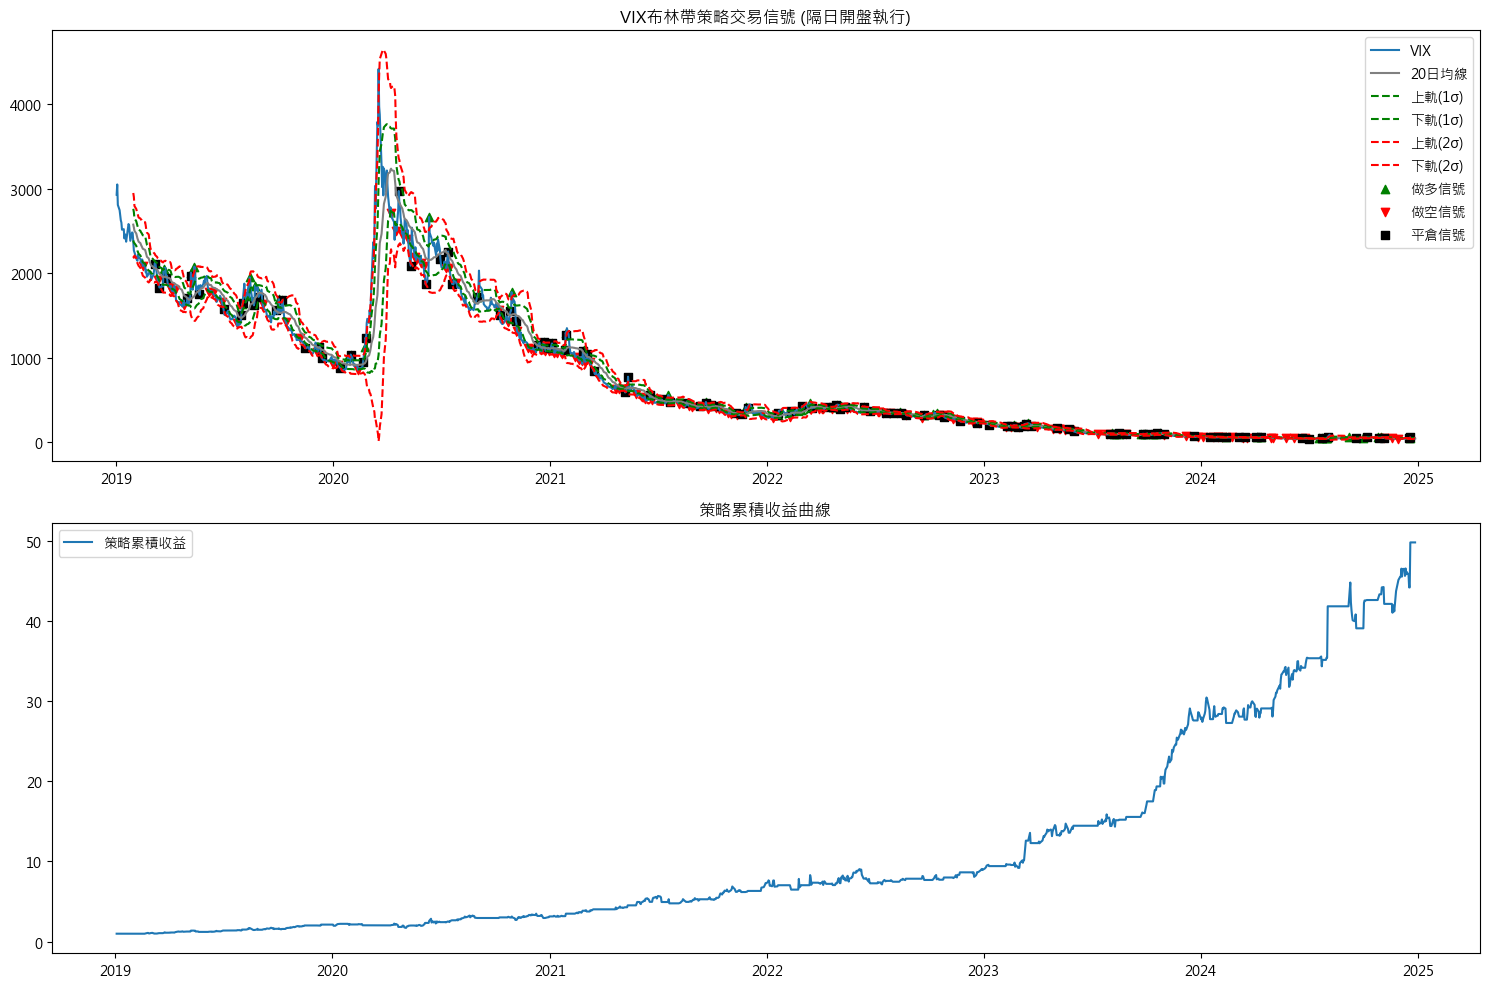


20日布林帶策略回測結果: {'Total Return': 48.77436775187927, 'Annual Return': 8.150623788775581, 'Sharpe Ratio': 1.7750643714000551, 'Active Days': 773, 'Total Days': 1508}

=== 詳細交易分析 ===

=== 交易統計摘要 ===
總交易次數: 110
獲利交易: 52
虧損交易: 58
勝率: 47.27%
平均報酬率: 0.43%
平均獲利交易報酬率: 9.31%
平均虧損交易報酬率: -7.53%
平均持倉天數: 10.1
最大單筆獲利: 95.33%
最大單筆虧損: -23.99%
總報酬率: -23.90%

=== 詳細交易記錄 ===
          進場時間  部位         進場價格       出場時間         出場價格  持倉天數      報酬率
0   2019-02-19  做空  2122.879883 2019-03-08  2177.280029    17   -2.56%
1   2019-03-13  做空  1903.359985 2019-03-18  1843.839966     5    3.13%
2   2019-03-25  做多  2056.959961 2019-03-27  1941.760010     2   -5.60%
3   2019-04-02  做空  1845.760010 2019-05-02  1705.599976    30    7.59%
4   2019-05-08  做多  1983.359985 2019-05-09  2073.600098     1    4.55%
5   2019-05-14  做多  1999.359985 2019-05-22  1766.400024     8  -11.65%
6   2019-06-07  做空  1777.280029 2019-07-02  1574.400024    25   11.42%
7   2019-07-24  做空  1429.760010 2019-08-01  1512.959961     8   -5.82%
8   

C:\Users\User\AppData\Local\Temp\ipykernel_14836\2284043711.py:142: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]


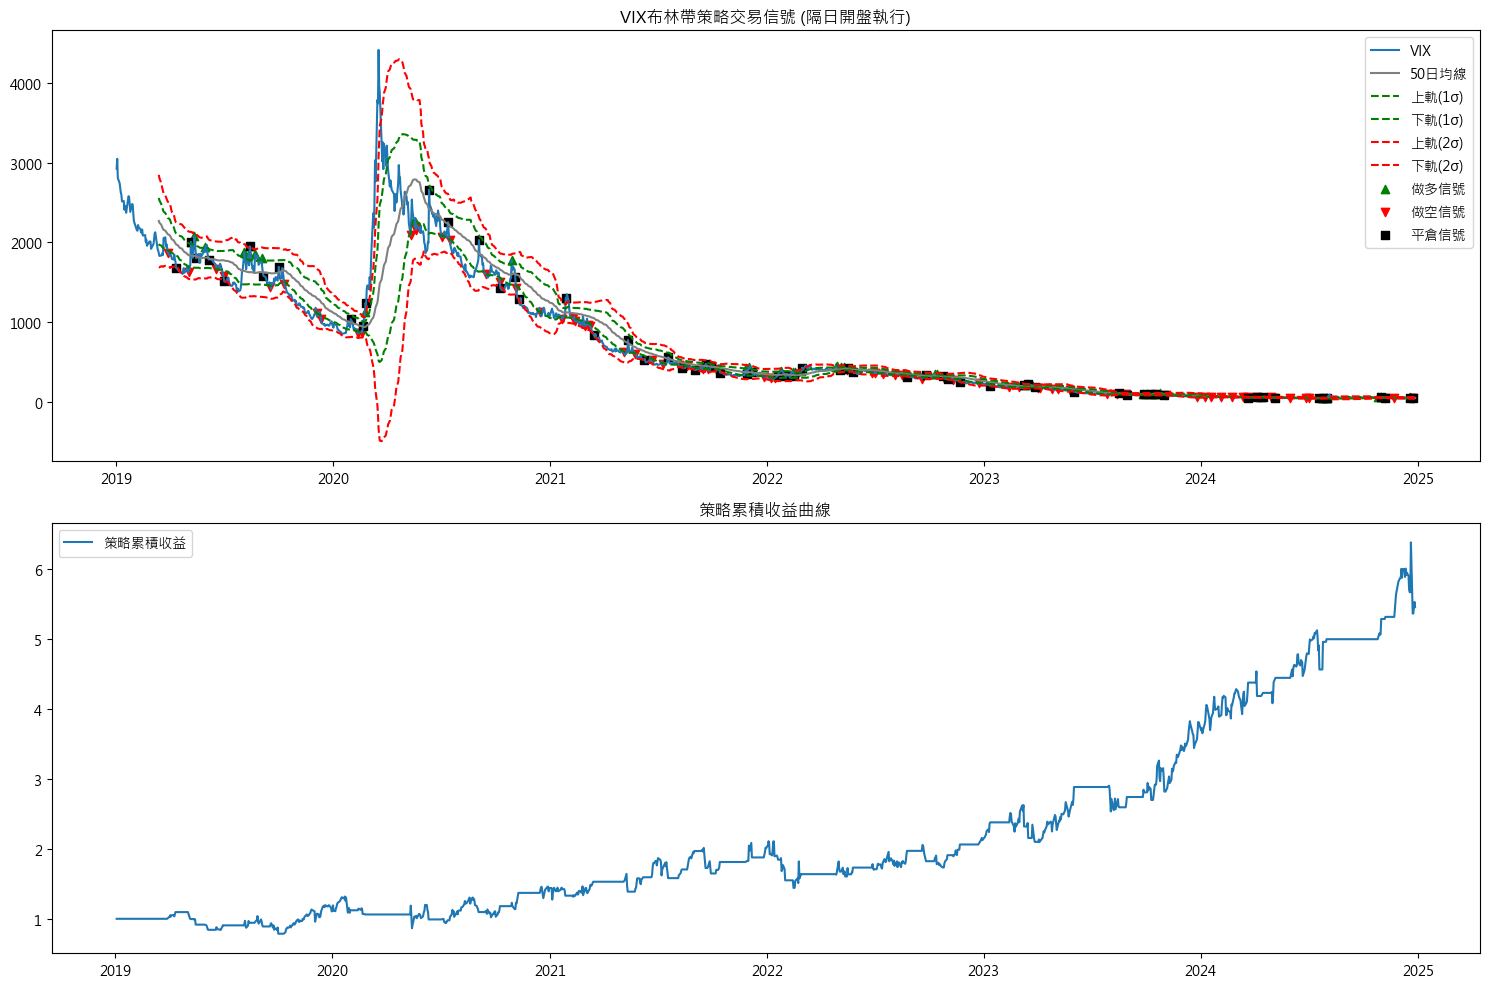


50日布林帶策略回測結果: {'Total Return': 4.46071019404326, 'Annual Return': 0.7454237194289798, 'Sharpe Ratio': 0.878423608752705, 'Active Days': 733, 'Total Days': 1508}

=== 詳細交易分析 ===

=== 交易統計摘要 ===
總交易次數: 64
獲利交易: 30
虧損交易: 34
勝率: 46.88%
平均報酬率: -1.23%
平均獲利交易報酬率: 10.77%
平均虧損交易報酬率: -11.82%
平均持倉天數: 16.4
最大單筆獲利: 37.24%
最大單筆虧損: -28.12%
總報酬率: -75.12%

=== 詳細交易記錄 ===
         進場時間  部位         進場價格       出場時間         出場價格  持倉天數      報酬率
0  2019-04-01  做空  1854.079956 2019-04-15  1655.680054    14   10.70%
1  2019-05-06  做空  1789.439941 2019-05-08  1983.359985     2  -10.84%
2  2019-05-14  做多  1999.359985 2019-05-17  1871.359985     3   -6.40%
3  2019-06-03  做多  1945.599976 2019-06-07  1777.280029     4   -8.65%
4  2019-06-20  做空  1629.439941 2019-07-03  1514.880005    13    7.03%
5  2019-08-06  做多  1806.079956 2019-08-15  1902.079956     9    5.32%
6  2019-08-26  做多  1761.920044 2019-09-09  1553.280029    14  -11.84%
7  2019-09-19  做空  1424.000000 2019-10-03  1687.040039    14  -18.47%
8  2019-10-1

C:\Users\User\AppData\Local\Temp\ipykernel_14836\2284043711.py:142: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]


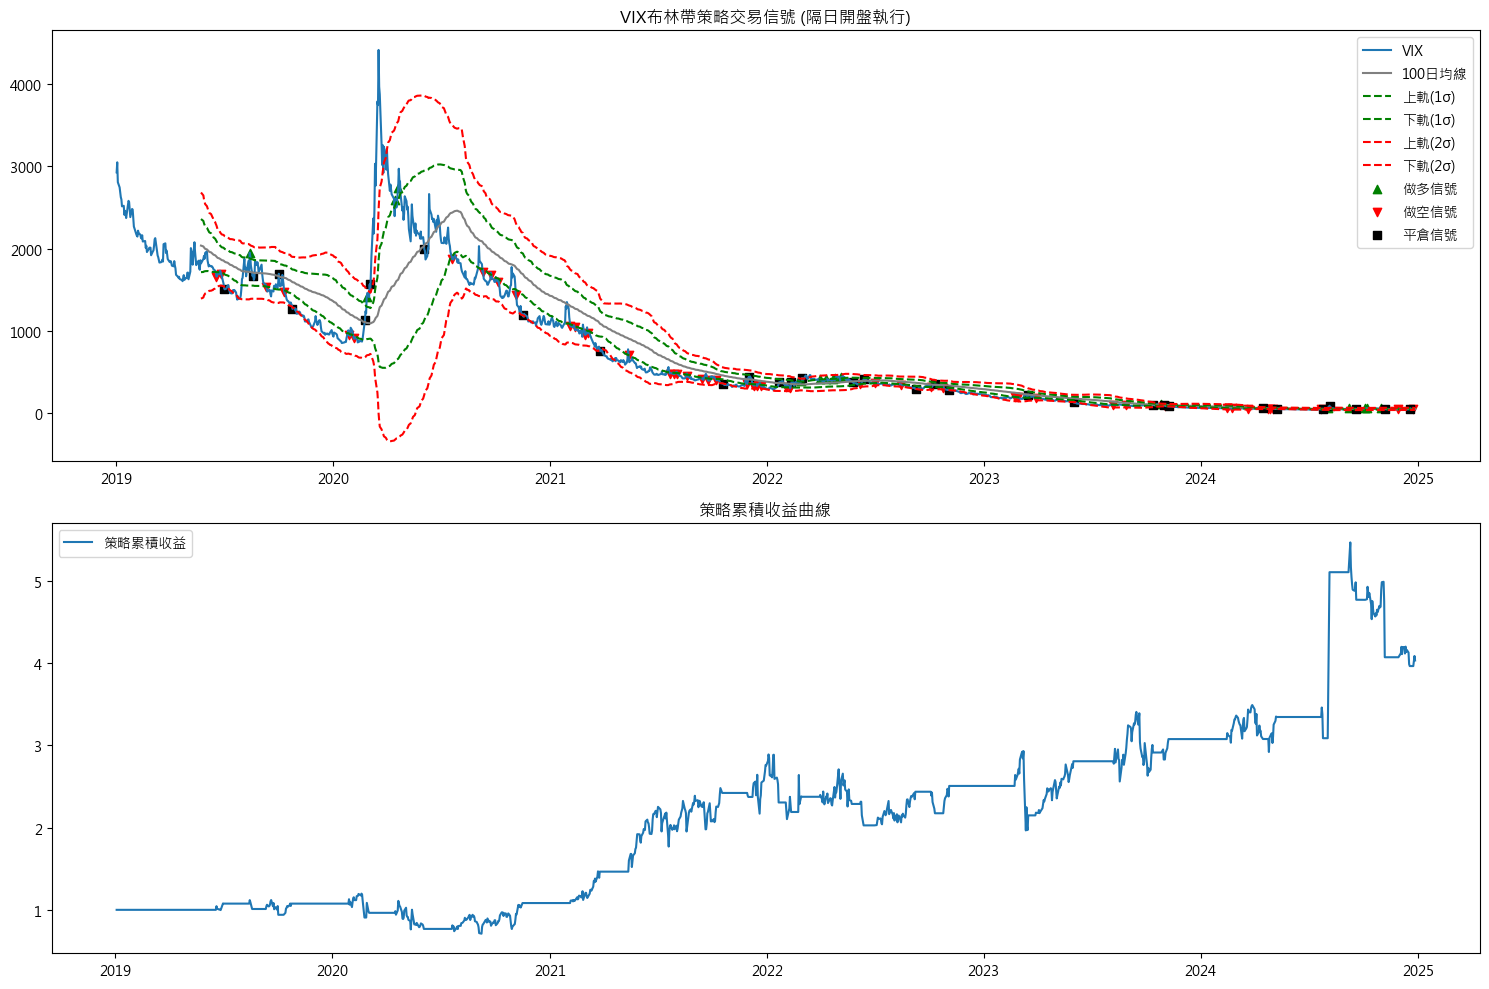


100日布林帶策略回測結果: {'Total Return': 3.0335034601042423, 'Annual Return': 0.5069249813967301, 'Sharpe Ratio': 0.6881409064160535, 'Active Days': 683, 'Total Days': 1508}

=== 詳細交易分析 ===

=== 交易統計摘要 ===
總交易次數: 31
獲利交易: 11
虧損交易: 20
勝率: 35.48%
平均報酬率: -1.23%
平均獲利交易報酬率: 19.60%
平均虧損交易報酬率: -12.69%
平均持倉天數: 31.6
最大單筆獲利: 46.42%
最大單筆虧損: -23.38%
總報酬率: -56.38%

=== 詳細交易記錄 ===
         進場時間  部位         進場價格       出場時間         出場價格  持倉天數      報酬率
0  2019-06-20  做空  1629.439941 2019-07-03  1514.880005    13    7.03%
1  2019-08-15  做多  1902.079956 2019-08-20  1680.640015     5  -11.64%
2  2019-09-12  做空  1508.479980 2019-10-03  1687.040039    21  -11.84%
3  2019-10-14  做空  1478.400024 2019-10-28  1261.439941    14   14.68%
4  2020-01-29  做空   932.479980 2020-02-25  1091.839966    27  -17.09%
5  2020-02-28  做多  1581.439941 2020-03-04  1497.599976     5   -5.30%
6  2020-04-16  做多  2613.760010 2020-06-04  2002.560059    49  -23.38%
7  2020-07-21  做空  1824.000000 2020-11-17  1215.359985   119   33.37%
8  2021-

In [5]:

# 對多個週期進行回測
periods = [20, 50, 100]
strategies = {}
trades_records = {}
for period in periods:
    strategies[period], trades_records[period], _ = run_strategy(vxx, period)